---
title: (Un)successfully Implementing DiffEdit
subtitle: The (Un)expected Difficulties of Editing
description: An attempt at implementing the DiffEdit paper.
image: ../images/15_un_successfully_implementing_diffedit/thumbnail.png
author: Salman Naqvi
date: '2023-05-25'
categories: [Diffusion, Creating Models, Papers]
open-graph:
  description: An attempt at implementing the DiffEdit paper.
  image: ../images/15_un_successfully_implementing_diffedit/thumbnail.png
twitter-card:
  description: An attempt at implementing the DiffEdit paper.
  image: ../images/15_un_successfully_implementing_diffedit/thumbnail.png
format: 
  html: default
  ipynb: default

reference-location: margin
---

> This notebook follows the [fastai style guide](https://docs.fast.ai/dev/style.html).

![](../images/15_un_successfully_implementing_diffedit/thumbnail.png)

Well, my implementation was a partial success: I managed to generate a mask, but failed to apply it. If you don't understand, hold on as I'll explain DiffEdit.

In this notebook, I try to implement the [DiffEdit](https://arxiv.org/abs/2210.11427) paper: a diffusion algorithm that allows us to replace the subject of an image with another subject, simply through a text prompt.

:::{.callout-warning appearance='simple'}
This notebook does not closely follow the paper implementation of DiffEdit. However, it does capture the underlying mechanisms.
:::

In a nutshell, this is done by generating a mask from the text prompt. This mask cuts out the subject from the image, which allows a new subject to be added to the image.

While I was successful in genreating a mask, I wasn't successful in applying it to an image. So at the end of this notebook, I'll use the [Hugging Face Stable Diffusion Inpaint Pipeline](https://huggingface.co/docs/diffusers/api/pipelines/stable_diffusion/inpaint) to see the mask in action.

If you would like a refresher on how Stable Diffusion can be implemented from its various components, you can read my post on this [here](https://forbo7.github.io/forblog/posts/13_implementing_stable_diffusion_from_its_components.html).

## Basic Workings

Let's say we have an image of a horse in front of a forest. We want to replace the horse with a zebra. At a high level, DiffEdit achieves this in the following manner. 

1. Using our image, we generate a further image with the prompt 'horse'.
1. We similarly generate another further image with the prompt 'zebra'.
1. The difference between both generated images is then taken.
1. The difference is normalized[^1] and binarized[^2] to obtain the mask.
1. We again generate an image with the prompt 'zebra'.
    * However this time, after each denoising step, apply the mask to the latent to obtain a cutout of the zebra.
    * Then add the noised background pixels of the original image to the cutout.

[^1]: In this case, normalizing means scaling the values to be between 0 and 1.
[^2]: Binarizing means making values be any of 2 possible values. In this case, either 0 or 1.

## Setup

In [1]:
! pip install -Uqq fastcore transformers diffusers

In [2]:
import logging; logging.disable(logging.WARNING) # <1>
from fastcore.all import *
from fastai.imports import *
from fastai.vision.all import *


1. Hugging Face can be verbose.

## Get Components

In [3]:
from transformers import CLIPTokenizer, CLIPTextModel

tokz = CLIPTokenizer.from_pretrained('openai/clip-vit-large-patch14', torch_dtype=torch.float16)
txt_enc = CLIPTextModel.from_pretrained('openai/clip-vit-large-patch14', torch_dtype=torch.float16).to('cuda')

In [4]:
from diffusers import AutoencoderKL, UNet2DConditionModel

vae = AutoencoderKL.from_pretrained('stabilityai/sd-vae-ft-ema', torch_dtype=torch.float16).to('cuda')
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to("cuda")

In [5]:
from diffusers import LMSDiscreteScheduler

sched = LMSDiscreteScheduler(
    beta_start = 0.00085,
    beta_end = 0.012,
    beta_schedule = 'scaled_linear',
    num_train_timesteps = 1000
)









## Simple Loop

In this simple loop, I'm making sure I can correctly generate an image based on another image as the starting point.

### Hyperparameters

In [6]:
prompt = ['earth']
neg_prompt = ['']
w, h = 512, 512
n_inf_steps = 50
g_scale = 8
bs = 1
seed = 77

### Encode Prompt

In [7]:
txt_inp = tokz(
    prompt,
    padding = 'max_length',
    max_length = tokz.model_max_length,
    truncation = True,
    return_tensors = 'pt',
)

In [8]:
txt_emb = txt_enc(txt_inp['input_ids'].to('cuda'))[0].half()

In [9]:
neg_inp = tokz(
    [''] * bs,
    padding = 'max_length',
    max_length = txt_inp['input_ids'].shape[-1],
    return_tensors = 'pt'
)

In [10]:
neg_emb = txt_enc(neg_inp['input_ids'].to('cuda'))[0].half()

In [11]:
embs = torch.cat([neg_emb, txt_emb])

### Compress Image

In [12]:
!curl --output planet.png 'https://images.unsplash.com/photo-1630839437035-dac17da580d0?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=2515&q=80'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  188k  100  188k    0     0  4829k      0 --:--:-- --:--:-- --:--:-- 4829k


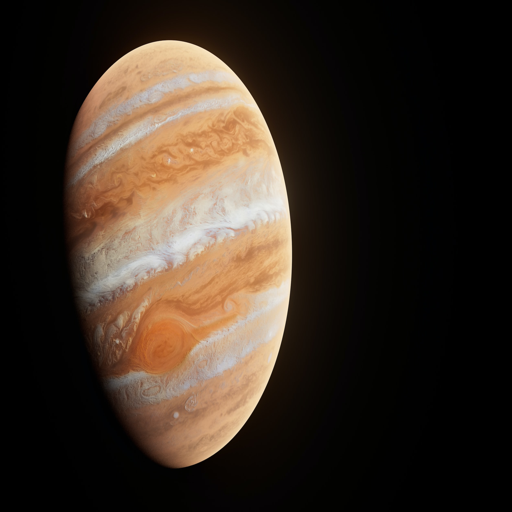

In [13]:
img = Image.open('/content/planet.png').resize((512, 512)); img

In [14]:
import torchvision.transforms as T
with torch.no_grad():
  img = T.ToTensor()(img).unsqueeze(0).half().to('cuda') * 2 - 1
  lat = vae.encode(img)
  lat = 0.18215 * lat.latent_dist.sample(); lat.shape

Below we can see the all 4 channels of the compressed image.

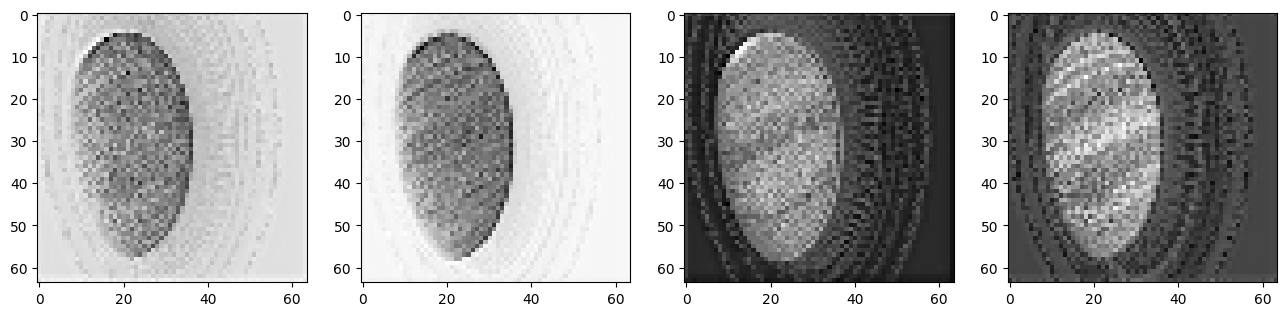

In [15]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for c in range(4):
  axs[c].imshow(lat[0][c].cpu(), cmap='Greys')

### Noise Image

In [16]:
sched = LMSDiscreteScheduler(
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule='scaled_linear',
    num_train_timesteps=1000
); sched

LMSDiscreteScheduler {
  "_class_name": "LMSDiscreteScheduler",
  "_diffusers_version": "0.16.1",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "trained_betas": null
}

In [17]:
sched.set_timesteps(n_inf_steps)

In [18]:
torch.manual_seed(seed)
noise = torch.randn_like(lat)
sched.timesteps = sched.timesteps.to(torch.float32)
start_step = 10
ts = tensor([sched.timesteps[start_step]])
lat = sched.add_noise(lat, noise, timesteps=ts)

### Denoise

In [20]:
from tqdm.auto import tqdm

for i, ts in enumerate(tqdm(sched.timesteps)):
  if i >= start_step:
    inp = torch.cat([lat] * 2)
    inp = sched.scale_model_input(inp, ts)

    with torch.no_grad(): preds = unet(inp, ts, encoder_hidden_states=embs)['sample']

    pred_neg, pred_txt = preds.chunk(2)
    pred = pred_neg + g_scale * (pred_txt - pred_neg)

    lat = sched.step(pred, ts, lat).prev_sample

  0%|          | 0/50 [00:00<?, ?it/s]

### Uncompress

In [21]:
lat.shape

torch.Size([1, 4, 64, 64])

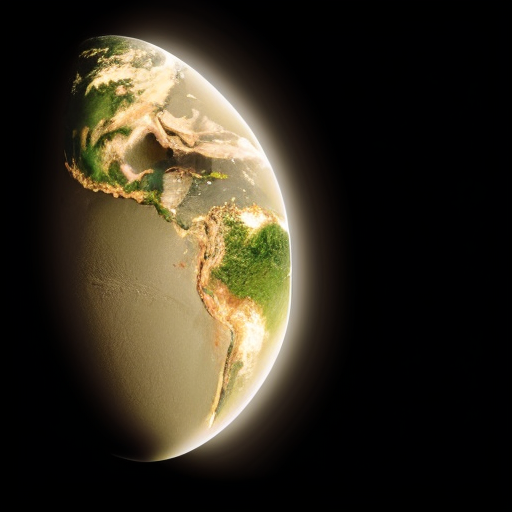

In [22]:
lat *= (1/0.18215)
with torch.no_grad(): img = vae.decode(lat).sample
img = (img / 2 + 0.5).clamp(0, 1)
img = img[0].detach().cpu().permute(1, 2, 0).numpy()
img = (img * 255).round().astype('uint8')
Image.fromarray(img)

### Encapsulate

I'll encapsulate the code above so we can focus on DiffEdit.

In [23]:
def get_embs(prompt, neg_prompt):
  txt_inp = tok_seq(prompt)
  txt_emb = calc_emb(txt_inp['input_ids'])

  neg_inp = tok_seq(neg_prompt)
  neg_emb = calc_emb(neg_inp['input_ids'])

  return torch.cat([neg_emb, txt_emb])

def tok_seq(prompt):
  return tokz(
      prompt,
      padding = 'max_length',
      max_length = tokz.model_max_length,
      truncation = True,
      return_tensors = 'pt',
  )

def calc_emb(inp_ids):
  return txt_enc(inp_ids.to('cuda'))[0].half()

In [24]:
def get_lat(img, start_step=30):
  return noise_lat(compress_img(img), start_step)

def compress_img(img):
  with torch.no_grad():
    img = T.ToTensor()(img).unsqueeze(0).half().to('cuda') * 2 - 1
    lat = vae.encode(img)
    return 0.18215 * lat.latent_dist.sample()

def noise_lat(lat, start_step):
  torch.manual_seed(seed)
  noise = torch.randn_like(lat)

  sched.set_timesteps(n_inf_steps)
  sched.timesteps = sched.timesteps.to(torch.float32)
  ts = tensor([sched.timesteps[start_step]])

  return sched.add_noise(lat, noise, timesteps=ts)

In [25]:
def denoise(lat, ts):
  inp = torch.cat([lat] * 2)
  inp = sched.scale_model_input(inp, ts)

  with torch.no_grad(): preds = unet(inp, ts, encoder_hidden_states=embs)['sample']

  pred_neg, pred_txt = preds.chunk(2)
  pred = pred_neg + g_scale * (pred_txt - pred_neg)

  return sched.step(pred, ts, lat).prev_sample

In [26]:
def decompress(lat):
  with torch.no_grad(): img = vae.decode(lat*(1/0.18215)).sample
  img = (img / 2 + 0.5).clamp(0, 1)
  img = img[0].detach().cpu().permute(1, 2, 0).numpy()
  return (img * 255).round().astype('uint8')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  188k  100  188k    0     0  5232k      0 --:--:-- --:--:-- --:--:-- 5381k


  0%|          | 0/70 [00:00<?, ?it/s]

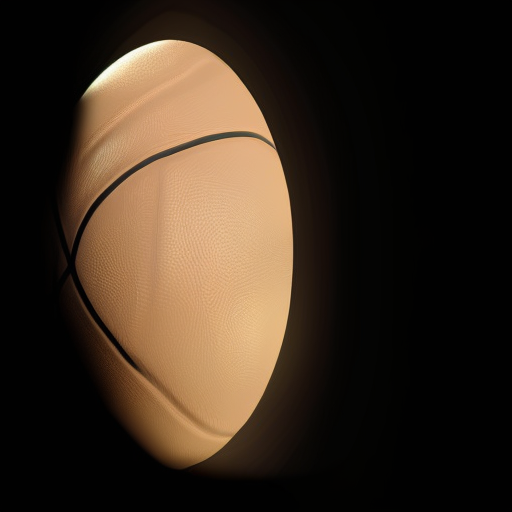

In [27]:
prompt = ['basketball']
neg_prompt = ['']
w, h = 512, 512
n_inf_steps = 70
start_step = 30
g_scale = 7.5
bs = 1
seed = 77

! curl --output img.png 'https://images.unsplash.com/photo-1630839437035-dac17da580d0?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=2515&q=80'
img = Image.open('/content/img.png').resize((512, 512))

embs = get_embs(prompt, neg_prompt)
lat = get_lat(img)
for i, ts in enumerate(tqdm(sched.timesteps)):
  if i >= start_step: lat = denoise(lat, ts)
img = decompress(lat)
Image.fromarray(img)

## DiffEdit

Let's review the steps of DiffEdit once more.

1. Using our image, we generate a further image with the prompt 'horse'.
1. We similarly generate another further image with the prompt 'zebra'.
1. The difference between both generated images is then taken.
1. The difference is normalized[^1] and binarized[^2] to obtain the mask.
1. We then again generate an image with the prompt 'zebra'.
    * However this time, after each denoising step, apply the mask to the latent to obtain a cutout of the zebra.
    * Then add the noised background pixels of the original image to the cutout.

[^1]: In this case, normalizing means scaling the values to be between 0 and 1.
[^2]: Binarizing means making values to be any of 2 possible values. In this case, either 0 or 1.

### Obtain two latents

First, we need to obtain an image of a horse and an image of a zebra.

We'll use this as our original image.

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  515k  100  515k    0     0  10.7M      0 --:--:-- --:--:-- --:--:-- 10.7M


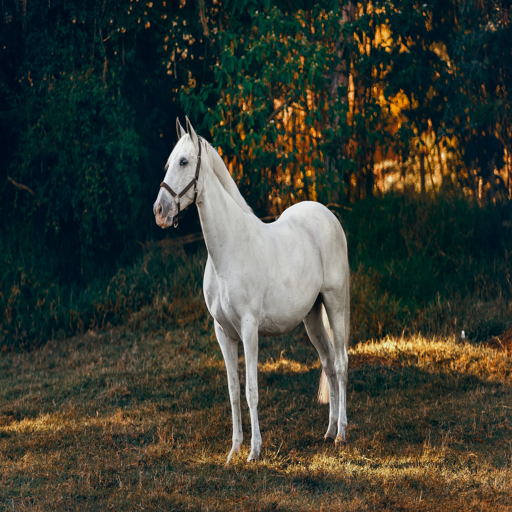

In [28]:
! curl --output img.png 'https://images.unsplash.com/photo-1553284965-fa61e9ad4795?ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&w=1742&q=80'
Image.open('/content/img.png').resize((512, 512))

This is the generated image of the horse.

In [29]:
prompt = ['horse']
img = Image.open('/content/img.png').resize((512, 512))
embs = get_embs(prompt, neg_prompt)
lat1 = get_lat(img)
for i, ts in enumerate(tqdm(sched.timesteps)):
  if i >= start_step: lat1 = denoise(lat1, ts)

  0%|          | 0/70 [00:00<?, ?it/s]

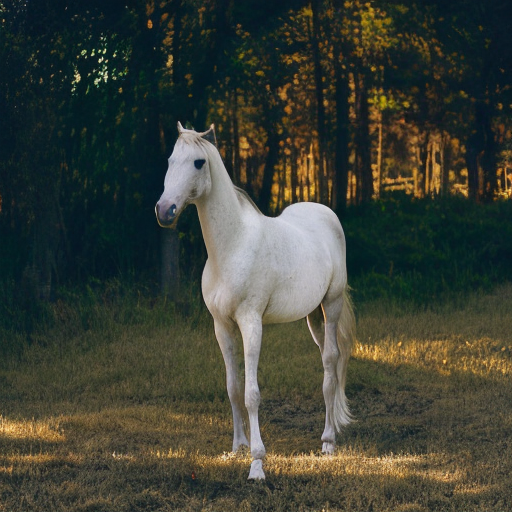

In [30]:
Image.fromarray(decompress(lat1))

And this is the generated image of the zebra.

In [31]:
prompt = ['zebra']
img = Image.open('/content/img.png').resize((512, 512))
embs = get_embs(prompt, neg_prompt)
lat2 = get_lat(img)
for i, ts in enumerate(tqdm(sched.timesteps)):
  if i >= start_step: lat2 = denoise(lat2, ts)

  0%|          | 0/70 [00:00<?, ?it/s]

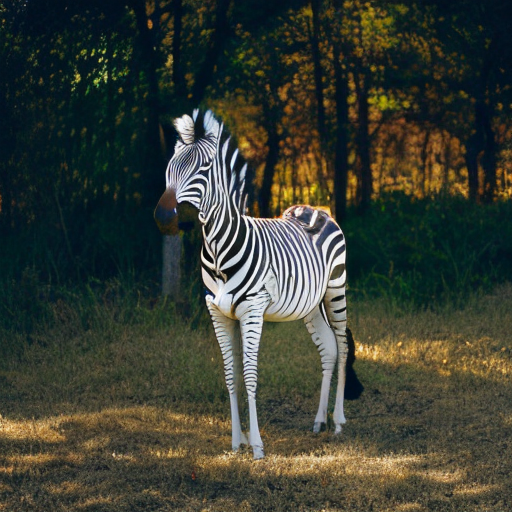

In [32]:
Image.fromarray(decompress(lat2))

In [33]:
lat1[:].shape

torch.Size([1, 4, 64, 64])

### Create Mask

We'll first convert the generated images to grayscale and then take their difference.

In [34]:
import torchvision.transforms.functional as F

img1 = F.to_tensor(F.to_grayscale(Image.fromarray(decompress(lat1[:]))))
img2 = F.to_tensor(F.to_grayscale(Image.fromarray(decompress(lat2[:]))))
diff = torch.abs(img1 - img2)

Then we'll normalize the difference to have values between 0 and 1.

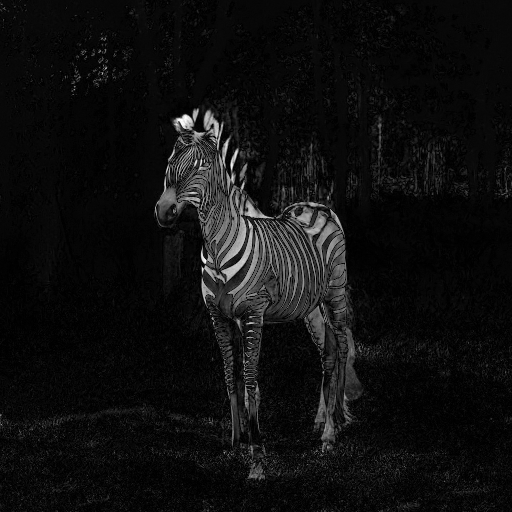

In [35]:
norm = diff / torch.max(diff)
Image.fromarray((norm*255).squeeze().numpy().round().astype(np.uint8))

And then finally binarize the values so they are either 0 or 1.

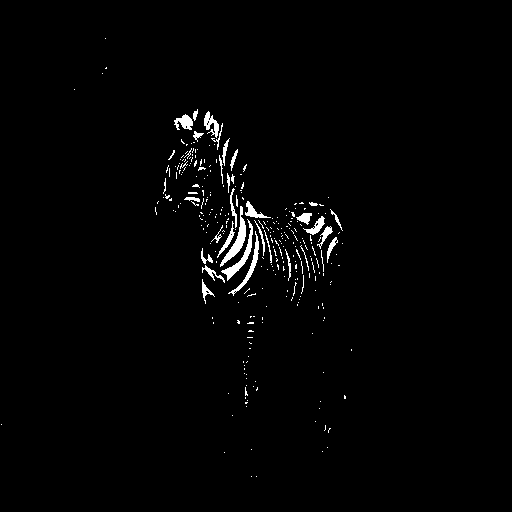

In [36]:
thresh = 0.5
bin = (norm > thresh).float()
Image.fromarray((bin.squeeze().numpy()*255).astype(np.uint8))

In [37]:
Image.fromarray((bin.squeeze().numpy()*255).astype(np.uint8)).save('mask.png')

Now we need to apply transformations to the binarized mask so it encapsulates the shape of the horbra/zeborse (horse + zebra 🫤). 

In [ ]:
import cv2 as cv
from google.colab.patches import cv2_imshow

mask = cv.imread('mask.png', cv.IMREAD_GRAYSCALE)
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (10, 10)) # <1>

The kernel is essentially a shape. Multiple shapes are be applied to the image in order to perform transformations.

I've chosen to use an ellipse of size 10 by 10 units.

Applying an erosion transformation makes our binarized mask look like this. Such transformations remove can remove small, noisy objects.

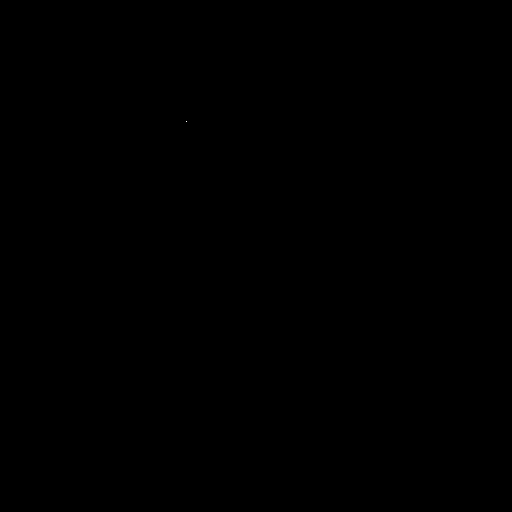

In [39]:
cv2_imshow(cv.erode(mask, kernel))

Applying a dilation transformation makes our binarized mask look like this. Such transformations can fill in gaps and smooth edges.

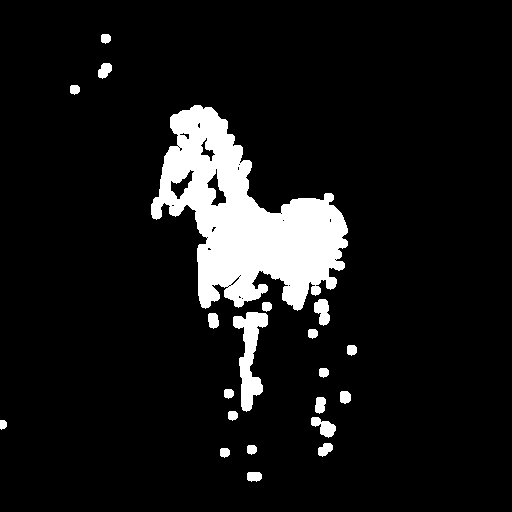

In [40]:
cv2_imshow(cv.dilate(mask, kernel))

To produce the final mask, I'll apply the closing transform[^5] 7 times consecutively...

[^5]: The closing transform is a dilation transform followed immediately by an erosion transform. This allows holes or small black points to be closed.

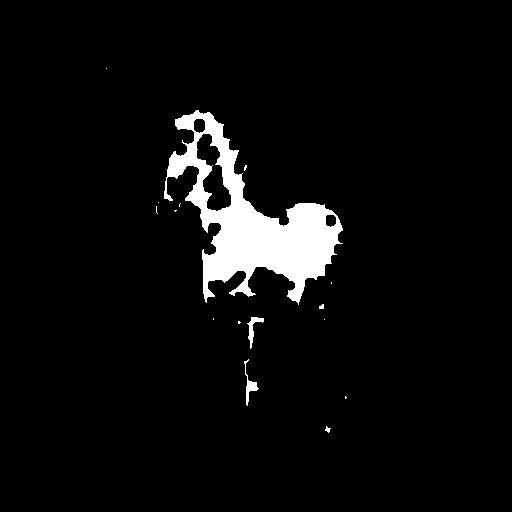

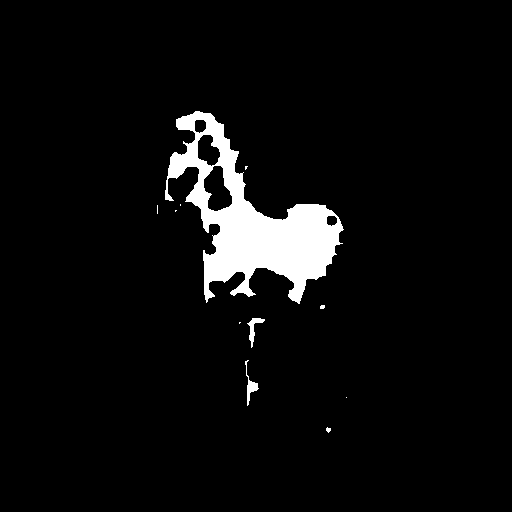

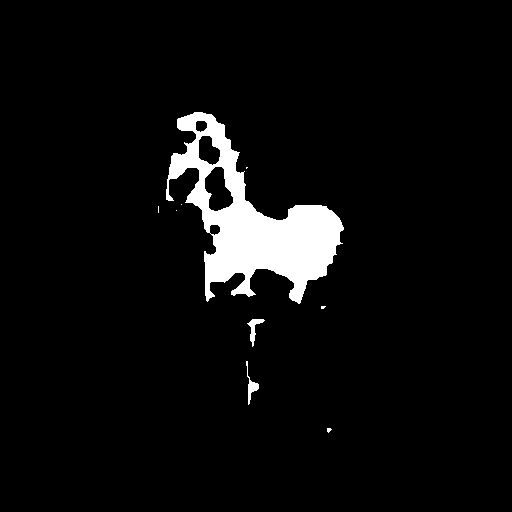

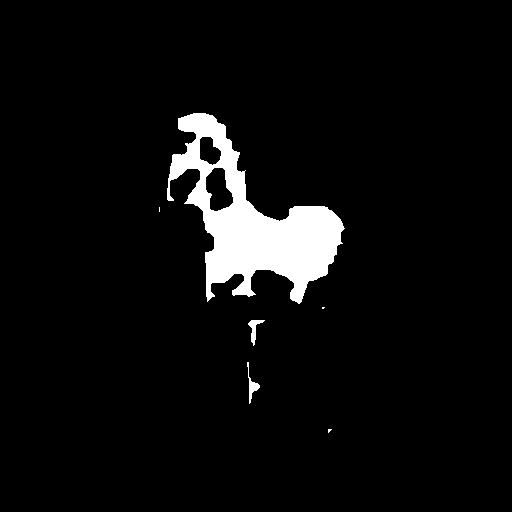

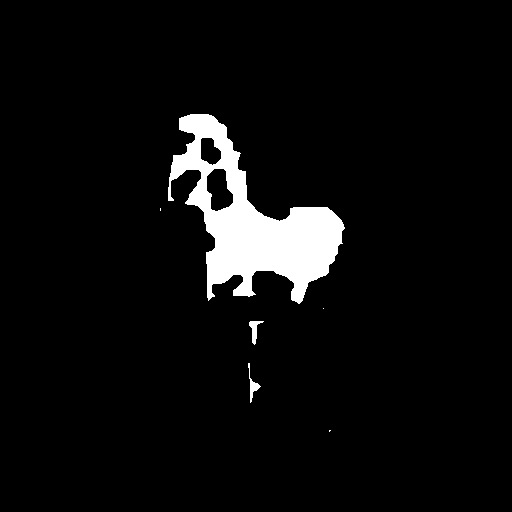

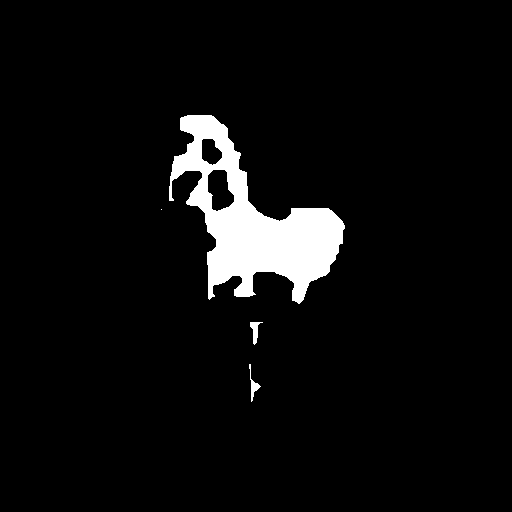

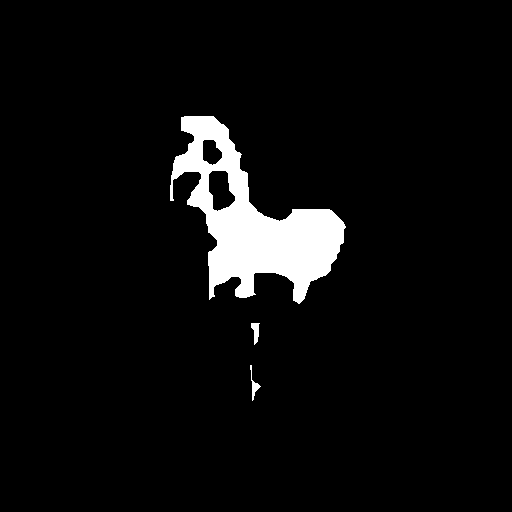

In [41]:
mask_closed = mask
for _ in range(7):
  mask_closed = cv.morphologyEx(mask_closed, cv.MORPH_CLOSE, kernel)
  cv2_imshow(mask_closed)

...and then apply the dilation transform 3 times consecutively.

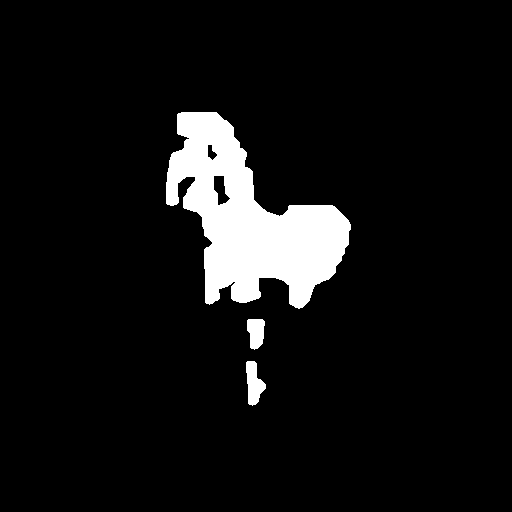

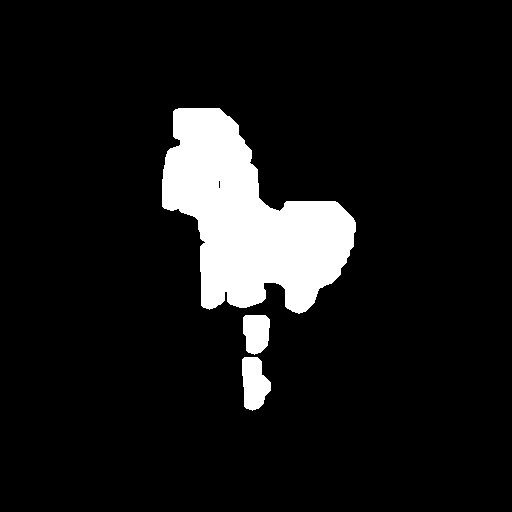

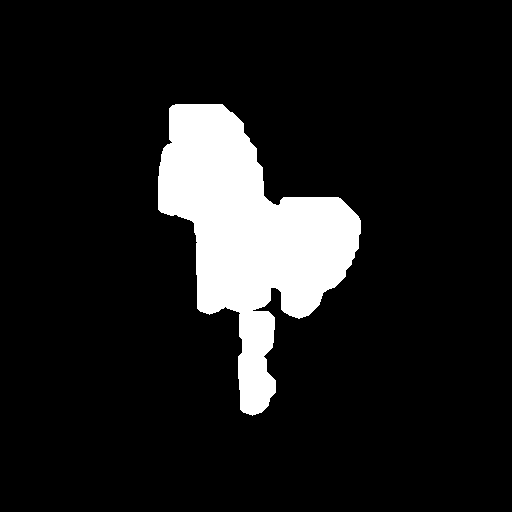

In [42]:
mask_dilated = mask_closed
for _ in range(3):
  mask_dilated = cv.dilate(mask_dilated, kernel)
  cv2_imshow(mask_dilated)

A more concise way of doing the above.

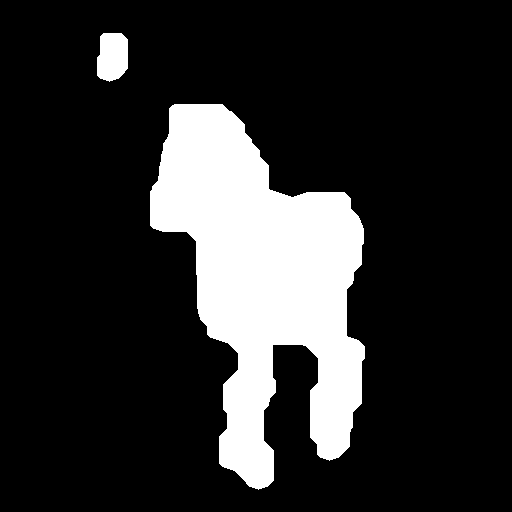

In [43]:
mask_closed = cv.morphologyEx(mask, cv.MORPH_CLOSE, kernel, iterations=7)
mask_dilated = cv.dilate(mask_closed, kernel, iterations=3)

cv2_imshow(mask_dilated)

Then I'll stack the mask together so I have a 3 channel image.

In [44]:
mask = np.stack((mask_dilated, mask_dilated, mask_dilated), axis=-1)/255; mask.shape

(512, 512, 3)

To read more about such transformations applied above, you can read them at the OpenCV docs [here](https://docs.opencv.org/3.4/d9/d61/tutorial_py_morphological_ops.html).

### Apply Mask

Now for the part I couldn't figure out how to do.

By applying the mask to the original iamge. This is how the cutout of the horse looks like.

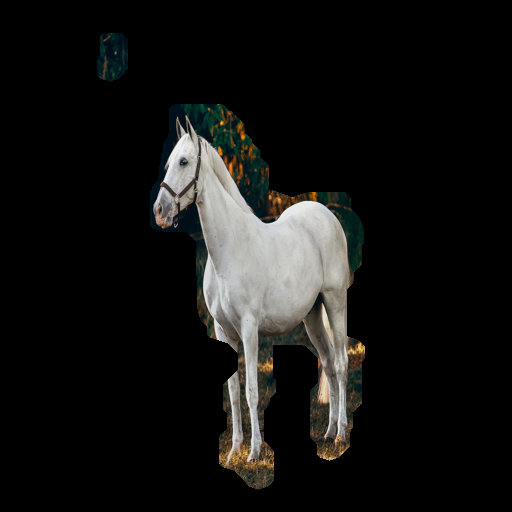

In [45]:
fore = torch.mul(F.to_tensor(img).permute(1, 2, 0), torch.from_numpy(mask))
Image.fromarray((fore*255).numpy().round().astype('uint8'))

You can see that it does not exactly cut out the outline: this is good because different subjects will have different levels of protrusion.

And this is how the background pixels look like.

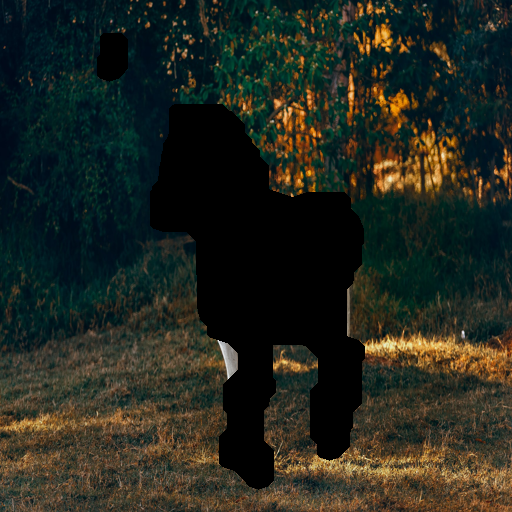

In [46]:
inv_mask = 1 - mask
back = torch.mul(F.to_tensor(img).permute(1, 2, 0), torch.from_numpy(inv_mask))
Image.fromarray((back*255).numpy().round().astype('uint8'))

Adding both the foreground and the background together...

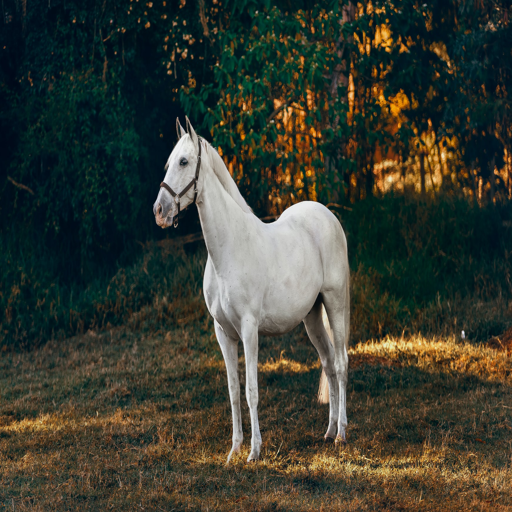

In [47]:
Image.fromarray(((fore+back)*255).numpy().round().astype(np.uint8))

---

#### Detour {.unnumbered .unlisted}

Note the subtle, yet very important difference in the two cells below, along with their output.

In [48]:
x = tensor([1, 2, 3])
def foo(y):
  y += 1
  return y
foo(x)
x

tensor([2, 3, 4])

In [49]:
x = tensor([1, 2, 3])
def foo(y):
  z = y + 1
  return z
foo(x)
x

tensor([1, 2, 3])

This was the reason for the bug that had me pulling my hair out for hours — when you pass a list or any list-like object (or even just objects I think), a copy is not passed, but rather the same object.

---

However, I can't quite correctly apply the mask to the latent when denoising.

In [50]:
prompt = ['zebra']
img = Image.open('/content/img.png').resize((512, 512))
embs = get_embs(prompt, neg_prompt)
lat = get_lat(img)
inv_mask = 1 - mask
# back = torch.mul(F.to_tensor(img).permute(1, 2, 0), torch.from_numpy(inv_mask))


for i, ts in enumerate(tqdm(sched.timesteps)):
  if i >= start_step: 
  # TODO: Visualize the latent at each loop

    back = torch.mul(torch.from_numpy(decompress(get_lat(img, start_step=i)))/255, torch.from_numpy(inv_mask))
    fore = torch.mul(torch.from_numpy(decompress(lat))/255, torch.from_numpy(mask))
    bafo = (back + fore)*255
    lat = compress_img(Image.fromarray(bafo.numpy().round().astype(np.uint8)))

  0%|          | 0/70 [00:00<?, ?it/s]

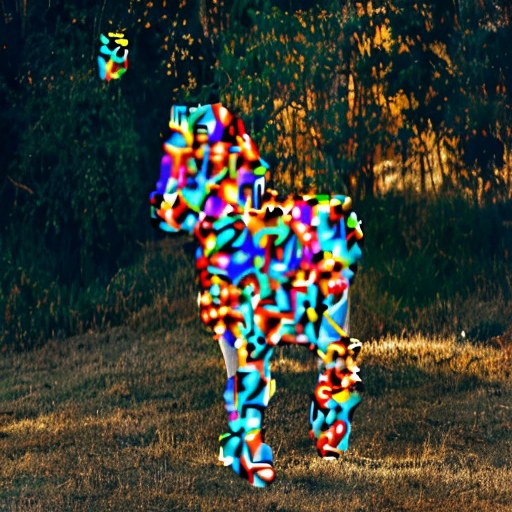

In [51]:
Image.fromarray(decompress(lat))

After asking on the fastai forum, and hours of fiddling about, the reason why this is happening is most likely due to the fact that I keep uncompressing and recompressing the latent. The compression that the VAE performs is lossy, so detail is lost during each compression and decompression.

My mask is not calculated in the same latent space as my latent. In other words, my mask was calculated as a 512x512 pixel and 3 channel image, whereas my latent is a 64x64 pixel and 4 channel image. I'm uncompressing the latent so that I can apply the mask to cutout the zebra and add the background pixels, and then recompressing.

To fix this, I would need to generate the mask as a 64x64 pixel and 3 channel image.

To at least see the mask in action, let's use the Hugging Face Stable Diffusion Pipeline.

## Pipeline

The Hugging Face Stable Diffusion pipeline works by simply providing the starting image and a mask. The pipeline will handle the rest.

In [52]:
from diffusers import StableDiffusionInpaintPipeline
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    revision="fp16",
    torch_dtype=torch.float16,
).to("cuda")

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


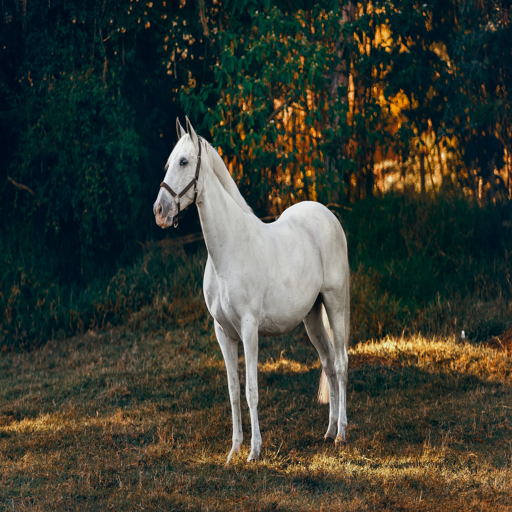

In [53]:
img

  0%|          | 0/25 [00:00<?, ?it/s]

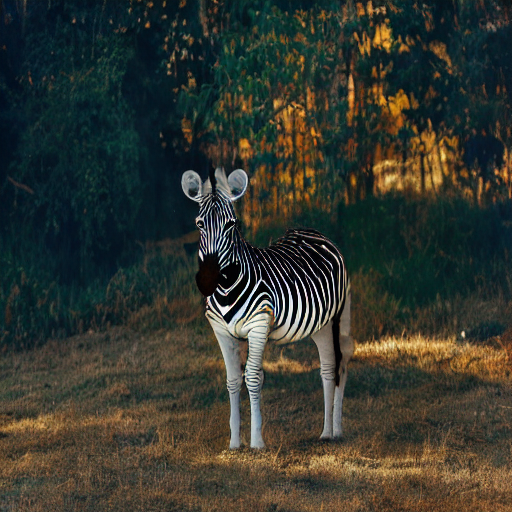

In [54]:
torch.manual_seed(77)
# 35 or 25 steps are good
out = pipe(
    prompt=["zebra"], 
    image=img, 
    mask_image=Image.fromarray((mask*255).round().astype(np.uint8)), 
    num_inference_steps = 25
).images
out[0]

## Takeaways

Looking back, the actual problem for me was that I let the paper feel intimidating; all those symbols, variables, jargon, and notation. I ended up glazing over the paper and missing the smaller details.

To help prevent this the next time, I should
* list out the variables and what they represent
* write out the steps in simpler terms
* and take a deep breath before reading, so I take things slowly.

And that's that.

If you have any comments, questions, suggestions, feedback, criticisms, or corrections, please do post them down in the comment section below!